# Turbulence Development Over Complex Terrain
This notebook contains the necessary code to analyze the SOWFA simulations that are used to determine the effectiveness of terrain in generating turbulence.

## Import necessary libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sowfadict as sowfa
import subprocess
import tools
from scipy.stats import norm
from scipy.stats import skew,kurtosis
import pandas as pd
import inflowPrepMMC as inflowprep
from matplotlib.colors import Normalize

## Show terrain cases with towers
This is taken from ~/Code/Python/CreateProbeLines.swfa.py
### Define user variables

In [2]:
# - - - - - - - - USER INPUT - - - - - - - -  
fdir     = '/projects/mmc/NWTCRegion/meshes/'
casename = ['SR_20m','DiffF2_20m']
ncases   = np.shape(casename)[0]
#boundaryDir = SET YOUR DIRECTORY TO THE LOWER BOUNDARY POINTS HERE!


dx = 20.0 # grid spacing over lowest model mesh
hdx = dx/2.0
# Start of the lines (bottom or left)
linestartx = [-12000,-10000,-8000,-6000,-4000,-2000,0,2000]
linestartx = [x+hdx for x in linestartx]
# Center of the lines -- will build outward from this point
linestartc = [hdx,hdx,hdx,hdx,hdx,hdx,hdx,hdx]
lineaxis   = ['v','v','v','v','v','v','v','v']
twc = ['darkred','red','orange','gold','darkgreen','darkblue','indigo','darkviolet']
ppl = 9 #probes per line
probespace = 280.0 # spacing between probes along the line 

nlines = np.shape(linestartx)[0]
if nlines != np.shape(linestartc)[0] or nlines != np.shape(lineaxis)[0]: print "Line starts do not match dimensions..."; exit()

# Heights of the probe AGL
probeZ = np.arange(10.001,500.0011,20.0)

lblsize = 14.0
txtsize = 12.0
legsize = 10.0
#- - - - - - - - - - - - - - - - - - - - - -  

### Where to save the figures

In [3]:
savedir = '/home/phawbeck/SOWFA/Terrain/img/'

### Get the boundary data

In [4]:
for cc in range(0,ncases):
    boundaryDir = '%sNWTC.meshGeneration.%s/' % (fdir,casename[cc])
    print boundaryDir
    boundary = inflowprep.inflowPrepMMC()
    boundary.readBoundaryDataPoints(boundaryDir + 'postProcessing/boundaryData/lower/points')

    dimf = open(boundaryDir + 'setUp','r')
    for line in dimf:
        line = line.split()
        if np.shape(line)[0] != 0:
            if line[0] == 'nx1':
                nx = int(line[1].replace(';',''))
            if line[0] == 'ny1':
                ny = int(line[1].replace(';',''))
    dimf.close()
    xy = boundary.xyz[:,0]; yx = boundary.xyz[:,1]; zf = boundary.xyz[:,2]
    xy = np.reshape(xy,(nx,ny))
    yx = np.reshape(yx,(nx,ny))
    zf = np.reshape(zf,(nx,ny))
    if cc == 0:
        xx = np.zeros((ncases,np.shape(xy)[0],np.shape(xy)[1]))
        yy = np.zeros((ncases,np.shape(xy)[0],np.shape(xy)[1]))
        zz = np.zeros((ncases,np.shape(xy)[0],np.shape(xy)[1]))
    xx[cc,:,:] = xy
    yy[cc,:,:] = yx
    zz[cc,:,:] = zf
        

/projects/mmc/NWTCRegion/meshes/NWTC.meshGeneration.SR_20m/
/projects/mmc/NWTCRegion/meshes/NWTC.meshGeneration.DiffF2_20m/


### Plot the terrain and towers

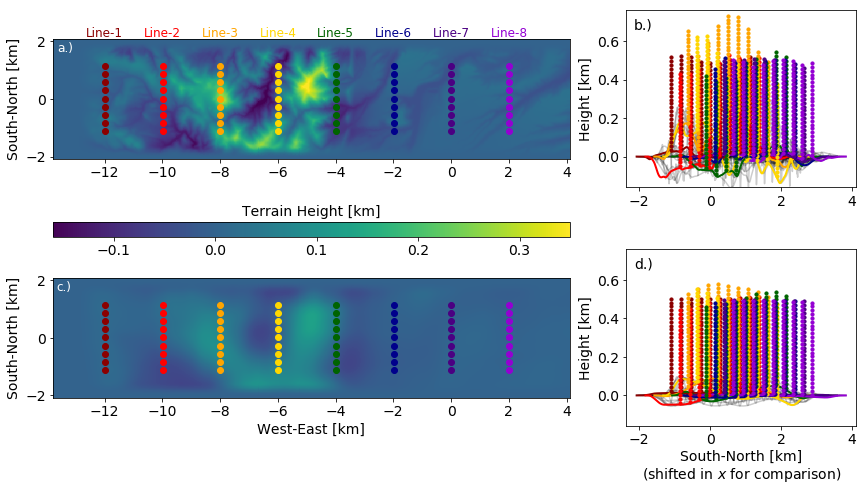

In [5]:
fig = plt.figure(figsize=(12,7))
fig.subplots_adjust(hspace=0.35,top=0.95,left=0.06,right=0.99,wspace=0.65)
for cc in range(0,ncases):
    horz = plt.subplot2grid((ncases,6),(cc,0),aspect='equal',colspan=4)
    horz.tick_params(labelsize=lblsize)
    cont = horz.pcolormesh(xx[cc,:,:]/1000.0,yy[cc,:,:]/1000.0,zz[cc,:,:]/1000.0,norm=Normalize(-.160,.350),rasterized=True)
    vert = plt.subplot2grid((ncases,6),(cc,4),colspan=2)#,aspect='equal')
    vert.tick_params(labelsize=lblsize)
    slope = 0.25

    for ii in range(0,nlines):
        if lineaxis[ii] == 'v':
            pxz = np.zeros((ppl,np.shape(probeZ)[0]))
            pyz = np.zeros((ppl,np.shape(probeZ)[0]))
            pzy = np.zeros((ppl,np.shape(probeZ)[0]))
            loix = linestartx[ii]
            for pp in range(0,ppl):
                loiy = linestartc[ii] + (pp - (ppl-1)/2)*probespace
                dist = ((xx[cc,:,:]-loix)**2 + (yy[cc,:,:]-loiy)**2)**0.5
                px,py = np.where(dist==np.min(dist))
                # - - - - - - - - - - - - - - - - - - - - - - - - - -
                # How should the values be determined?
                # z-values will be from the real mesh...
                pyz[pp,:] = yy[cc,px,py][0] # from the closest grid values?
                pxz[pp,:] = xx[cc,px,py][0] # from the closest grid values?
    #            pyz[pp,:] = loiy      # or from the generated values?
                # - - - - - - - - - - - - - - - - - - - - - - - - - -
                pzy[pp,:] = zz[cc,px,py][0]+probeZ

        vert.plot(yy[cc,px[0],:]/1000.0+(ii*slope),zz[cc,px[0],:]/1000.0,lw=2,zorder=2,c=twc[ii])
        vert.scatter(pyz/1000.0+(ii*slope),pzy/1000.0,s=10,zorder=3,c=twc[ii])
    for ii in range(0,nlines):
        loix = linestartx[ii]
        horz.scatter(np.ones((ppl))*loix/1000.0,pyz[:,0]/1000.0,c=twc[ii])
        if cc == 0: horz.text(loix/1000.0,2.05,'Line-%d' % (ii+1),size=txtsize,color=twc[ii],va='bottom',ha='center')
    horz.set_ylabel('South-North [km]',size=lblsize)
    if cc == ncases-1: horz.set_xlabel('West-East [km]',size=lblsize)
    if cc == 0: horz.text(-13.65,1.99,'a.)',color='w',ha='left',va='top',fontsize=txtsize)
    if cc == 1: horz.text(-13.65,1.99,'c.)',color='w',ha='left',va='top',fontsize=txtsize)


    for jj in range(0,ny,11):
        sBordS = yy[cc,0,jj]/1000.0 ; sBordE = yy[cc,-1,jj]/1000.0 + (nlines-1)*slope
        sBord = np.linspace(sBordS,sBordE,nx)
        vert.plot(sBord,zz[cc,:,jj]/1000.0,c='k',alpha=0.2,zorder=1)
    gridX = np.arange(0,nx,30)
    for ii in gridX:
        vert.plot(yy[cc,ii,:]/1000.0+((float(ii)/(gridX[-1]-1))*(nlines-1)*slope),zz[cc,ii,:]/1000.0,\
                  c='k',alpha=0.2,zorder=1)
    vert.plot(yy[cc,-1,:]/1000.0+((nlines-1)*slope),zz[cc,-1,:]/1000.0,c='k',alpha=0.2,zorder=1)
    #vert.plot(SoBord,zz[:,0]/1000.0,c='k')
    created = False

    vert.set_ylabel('Height [km]',size=lblsize)
    vert.set_ylim(-0.16,0.76)
    if cc == 0: vert.text(-2.15,0.72,'b.)',color='k',ha='left',va='top',fontsize=lblsize)
    if cc == 1: vert.text(-2.15,0.72,'d.)',color='k',ha='left',va='top',fontsize=lblsize)
vert.set_xlabel('South-North [km]\n(shifted in $x$ for comparison)',size=lblsize)

cax = fig.add_axes([0.06, 0.5, 0.599, 0.03])
cax.text(0.5,1.2,'Terrain Height [km]',ha='center',va='bottom',size=lblsize)
cbar = plt.colorbar(cont,cax,orientation='horizontal')
cbar.ax.tick_params(labelsize=lblsize)
plt.savefig('{}TerrainAndTowers.pdf'.format(savedir))
plt.show()

## Plot the time series data
### Declare user variables (cases, towers, colors, etc.) for tower data

In [6]:
cases   = ['M2_SR_Control']#,'M2_SR_NoTurbBC','M2_D2_TurbBC','M2_D2_NoTurbBC']
casec   = ['navy','darkturquoise','red','goldenrod']
casece  = [casec[0],'none',casec[2],'none']
casecf  = ['none',casec[1],'none',casec[3]]
casem   = ['o','o','d','d']
caselw  = ['3','2','3','2']
casea   = [0.8,1.0,0.8,1.0]
casesz  = [50,15,50,15]
ncases  = np.shape(cases)[0]

simstr  ='PGx2.2En4_zi550'

x = np.arange(0,101)

varns   = ['u','v','w','T']
nvars   = np.shape(varns)[0]

timedir = 14400

avgstart = 1799 # when do you want to start the averaging?
avgend   = -1 # when do you want to end the averaging?

lvl     = 5

twrs    = [1,3,5,7]
ntwrs   = np.shape(twrs)[0]

### Load in the data and store for manipulation & plotting

In [7]:
initIndividualTowerVars = True
initAvgTowerVars        = True
for cc in range(0,ncases):
    for tt in range(0,ntwrs):
        for vv in range(0,nvars):
            var = varns[vv]
            fdir      = '/projects/mmc/NWTCRegion/{}/NWTC.run.{}/postProcessing/'.format(simstr,cases[cc])
            #fdir      = '/projects/mmc/NWTCRegion/NWTC.run.%s/postProcessing/' % (cases[cc]) 
            pl        = 'probeLine%d' % twrs[tt]
            probeLine = sowfa.probeLine('%s%s/%d/' % (fdir,pl,timedir),'y',['U','T'])
            dt        = np.round(np.mean(probeLine.time[1:] - probeLine.time[:-1]),2)
            ntwr      = probeLine.ntowers; ntwrsq = int(np.sqrt(ntwr))
            if tt == 0: 
                tdz        = np.mean(probeLine.z[0,1:] - probeLine.z[0,:-1]) 
                twrheight  = probeLine.z[0,lvl] - probeLine.z[0,0] + tdz/2.0
                twrheightf = probeLine.z[0,:] - probeLine.z[0,0] + tdz/2.0
            for tw in np.arange(0,probeLine.ntowers):
                if var == 'u':
                    pvar   = probeLine.u[tw,lvl,avgstart:avgend]
                    avgvar = np.mean(probeLine.u[tw,:,avgstart:avgend],axis=1)
                    ff,psu = tools.spectra1d(probeLine.u[tw,lvl,avgstart:avgend],dt)
                elif var == 'v':
                    pvar   = probeLine.v[tw,lvl,avgstart:avgend]
                    avgvar = np.mean(probeLine.v[tw,:,avgstart:avgend],axis=1)
                    ff,psu = tools.spectra1d(probeLine.v[tw,lvl,avgstart:avgend],dt)
                elif var == 'w':
                    pvar   = probeLine.w[tw,lvl,avgstart:avgend]
                    avgvar = np.mean(probeLine.w[tw,:,avgstart:avgend],axis=1)
                    ff,psu = tools.spectra1d(probeLine.w[tw,lvl,avgstart:avgend],dt)
                elif var == 'T':
                    pvar   = probeLine.T[tw,lvl,avgstart:avgend]
                    avgvar = np.mean(probeLine.T[tw,:,avgstart:avgend],axis=1)
                    ff,psu = tools.spectra1d(probeLine.T[tw,lvl,avgstart:avgend],dt)
                varp = np.sort(pvar - np.mean(pvar))
                if initIndividualTowerVars == True:
                    print "initializing individual tower vars"
                    time       = probeLine.time[avgstart:avgend] 
                    ntimes     = np.shape(time)[0]
                    avgvarfull = np.zeros((nvars,ncases,ntwrs,ntwr,np.shape(avgvar)[0]))
                    tsvarfull  = np.zeros((nvars,ncases,ntwrs,ntwr,ntimes))
                    
                    initIndividualTowerVars = False
                if tw == 0:
                    varpf      = varp
                    lineavg    = avgvar
                    avgpsu     = psu
                else:
                    varpf    = np.append(varpf,varp)
                    lineavg += avgvar
                    avgpsu  += psu
                avgvarfull[vv,cc,tt,tw,:] = avgvar
                tsvarfull[vv,cc,tt,tw,:]  = pvar
            if initAvgTowerVars == True: 
                print "initializing avg tower vars"
                varpfull    = np.zeros((nvars,ncases,ntwrs,np.shape(varpf)[0]))
                lineavgfull = np.zeros((nvars,ncases,ntwrs,np.shape(lineavg)[0]))
                avgspec     = np.zeros((nvars,ncases,ntwrs,np.shape(avgpsu)[0]))
                initAvgTowerVars = False
            varpfull[vv,cc,tt,:]    = np.sort(varpf)
            lineavgfull[vv,cc,tt,:] = lineavg/probeLine.ntowers
            avgspec[vv,cc,tt,:]     = avgpsu/probeLine.ntowers
    print 'Done with case: {}'.format(cases[cc])

initializing individual tower vars
initializing avg tower vars
Done with case: M2_SR_Control


### Time series plots

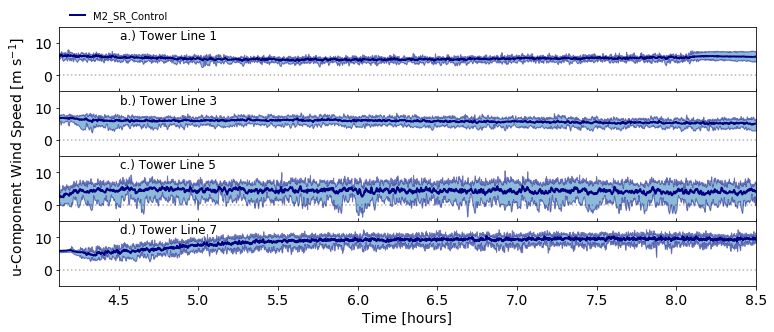

In [12]:
var = 'u'
varind = varns.index(var)
specfig = plt.figure(figsize=(11,4.5))
plt.subplots_adjust(left=0.08,right=0.96,bottom=0.13,top=0.93,hspace=0.0)
if var == 'u':
    ybot = -5; ytop = 15
elif var == 'v':
    ybot = -7; ytop = 7
elif var == 'w':
    ybot = -7; ytop = 7
if var == 'T':
    ybot = 299.8; ytop = 301.1
    pltstr = 'Potential Temperature [K]'
else:
    pltstr = '{}-Component Wind Speed [m s$^{{-1}}$]'.format(var)
legloc = (0.01,1.02)


plt1 = plt.subplot2grid((ntwrs,1),(0,0),rowspan=1)
plt2 = plt.subplot2grid((ntwrs,1),(1,0),rowspan=1,sharex=plt1)
plt3 = plt.subplot2grid((ntwrs,1),(2,0),rowspan=1,sharex=plt1)
plt4 = plt.subplot2grid((ntwrs,1),(3,0),rowspan=1,sharex=plt1)

#plt.setp(plt1.get_xticklabels(), visible=False)
#plt.setp(plt2.get_xticklabels(), visible=False)
#plt.setp(plt3.get_xticklabels(), visible=False)
plt1.axhline(0.0,c='k',ls=':',alpha=0.3)
plt2.axhline(0.0,c='k',ls=':',alpha=0.3)
plt3.axhline(0.0,c='k',ls=':',alpha=0.3)
plt4.axhline(0.0,c='k',ls=':',alpha=0.3)
ptime = time / 3600.0
ytics = [1e-2,1e-1,1e0,1e1,1e2,1e3,1e4,1e5,1e6,1e7]
xtics = np.arange(np.min(ptime),np.max(ptime)+0.1,0.5)
txtx = 6e-5
for cc in range(0,ncases):
    for tt in range(0,ntwrs):
        pmax = np.amax(tsvarfull[varind,cc,tt,:,:],axis = 0)
        pmin = np.amin(tsvarfull[varind,cc,tt,:,:],axis = 0)
        if tt == 0: plt1.fill_between(ptime,pmin,pmax,alpha=0.5,edgecolor=casec[cc],linewidth=1.0,facecolor=None)
        if tt == 1: plt2.fill_between(ptime,pmin,pmax,alpha=0.5,edgecolor=casec[cc],linewidth=1.0,facecolor=None)
        if tt == 2: plt3.fill_between(ptime,pmin,pmax,alpha=0.5,edgecolor=casec[cc],linewidth=1.0,facecolor=None)
        if tt == 3: plt4.fill_between(ptime,pmin,pmax,alpha=0.5,edgecolor=casec[cc],linewidth=1.0,facecolor=None)
    for tt in range(0,ntwrs):
        pavg = np.mean(tsvarfull[varind,cc,tt,:,:],axis = 0)
        if tt == 0: plt1.plot(ptime,pavg,color=casec[cc],linewidth=2.0,label=cases[cc])
        if tt == 1: plt2.plot(ptime,pavg,color=casec[cc],linewidth=2.0)
        if tt == 2: plt3.plot(ptime,pavg,color=casec[cc],linewidth=2.0)
        if tt == 3: plt4.plot(ptime,pavg,color=casec[cc],linewidth=2.0,label=cases[cc])

            
plt.xlim(np.min(ptime),np.max(ptime))

plt1.set_ylim((ybot,ytop))
plt2.set_ylim((ybot,ytop))
plt3.set_ylim((ybot,ytop))
plt4.set_ylim((ybot,ytop))

plt1.text(4.51,0.95*ytop,'a.) Tower Line %d' % twrs[0],ha='left',va='top',size=txtsize)
plt2.text(4.51,0.95*ytop,'b.) Tower Line %d' % twrs[1],ha='left',va='top',size=txtsize)
plt3.text(4.51,0.95*ytop,'c.) Tower Line %d' % twrs[2],ha='left',va='top',size=txtsize)
plt4.text(4.51,0.95*ytop,'d.) Tower Line %d' % twrs[3],ha='left',va='top',size=txtsize)
plt1.tick_params(axis='x',direction='in',labelbottom=False)
plt2.tick_params(axis='x',direction='in',labelbottom=False)
plt3.tick_params(axis='x',direction='in',labelbottom=False)
plt4.tick_params(axis='x',direction='out')
plt1.tick_params(labelsize=lblsize)
plt2.tick_params(labelsize=lblsize)
plt3.tick_params(labelsize=lblsize)
plt4.tick_params(labelsize=lblsize)
#plt4.set_xticks(xtics)
plt3.text(3.8,ytop,'{}'.format(pltstr),rotation=90,size=lblsize,va='center')
plt4.set_xlabel('Time [hours]',size=lblsize)
plt1.legend(frameon=False,loc=legloc,fontsize=legsize,ncol=2,handlelength=1.5)
plt.savefig('{}TimeSeries_{}{}m.pdf'.format(savedir,var,int(twrheight)))
plt.show()

In [ ]:
print np.shape(probeLine.u)

### Spectra plots
Calculate the spectra of the time series at various tower locations and plot the average along the tower-lines for each case

In [ ]:
var = 'u'
varind = varns.index(var)
specfig = plt.figure(figsize=(11,4.5))
plt.subplots_adjust(left=0.08,right=0.95,bottom=0.15,top=0.93,wspace=0.20)
if var == 'u':
    ybot = 1e-2; ytop = 2e4
elif var == 'w':
    ybot = 1e-2; ytop = 1e4
ytics = [1e-2,1e-1,1e0,1e1,1e2,1e3,1e4,1e5,1e6,1e7]
xtics = [1e-3,1e-2,1e-1]
txtx = 6e-5
plt1 = plt.subplot2grid((1,ntwrs),(0,0),rowspan=1)
plt2 = plt.subplot2grid((1,ntwrs),(0,1),rowspan=1)
plt3 = plt.subplot2grid((1,ntwrs),(0,2),rowspan=1)
plt4 = plt.subplot2grid((1,ntwrs),(0,3),rowspan=1)
plt1.tick_params(which='both',right=True,left=True)
plt2.tick_params(which='both',right=True,left=True,labelleft=False)
plt3.tick_params(which='both',right=True,left=True,labelleft=False)
plt4.tick_params(which='both',right=True,left=True,labelleft=False,labelright=True)
plt1.set_yticks(ytics)
plt2.set_yticks(ytics,'')
plt3.set_yticks(ytics,'')
plt4.set_yticks(ytics,'')
plt1.tick_params(labelsize=lblsize)
plt2.tick_params(labelsize=lblsize)
plt3.tick_params(labelsize=lblsize)
plt4.tick_params(labelsize=lblsize)
plt1.set_ylabel('$\kappa$F$_\mathrm{%s}$ [m$^2$ s$^{-1}$]' % var,size=lblsize)
plt3.text(txtx,1.1*ytop,'Spectra at %4.1f m' % twrheight,va='bottom',ha='center',size=lblsize)
plt3.text(txtx,0.2*ybot,'Frequency [s$^{-1}$]',va='top',ha='center',size=lblsize)
plt3.set_xticks(xtics)
plt2.tick_params(right=True,left=True)
plt3.tick_params(right=True,left=True)
plt4.tick_params(right=True,left=True)
plt1.set_ylim((ybot,ytop))
plt2.set_ylim((ybot,ytop))
plt3.set_ylim((ybot,ytop))
plt4.set_ylim((ybot,ytop))
plt1.text(1.25e-4,0.8*ytop,'a.) Tower Line %d' % twrs[0],ha='left',va='top',size=txtsize)
plt2.text(1.25e-4,0.8*ytop,'b.) Tower Line %d' % twrs[1],ha='left',va='top',size=txtsize)
plt3.text(1.25e-4,0.8*ytop,'c.) Tower Line %d' % twrs[2],ha='left',va='top',size=txtsize)
plt4.text(1.25e-4,0.8*ytop,'d.) Tower Line %d' % twrs[3],ha='left',va='top',size=txtsize)

for cc in range(0,ncases):
    for tt in range(0,ntwrs):
        krefx = np.arange(0.01,0.201,0.1)
        kshftA = 6.0*ybot*1e2
        kshftB = 5.0*ybot*1e3
        if tt == 0: plt1.loglog(ff,ff*avgspec[varind,cc,tt,:],c=casec[cc],alpha=casea[cc],nonposx='mask',label=cases[cc])
        if tt == 1: plt2.loglog(ff,ff*avgspec[varind,cc,tt,:],c=casec[cc],alpha=casea[cc],nonposx='mask')
        if tt == 2: plt3.loglog(ff,ff*avgspec[varind,cc,tt,:],c=casec[cc],alpha=casea[cc],nonposx='mask')
        if tt == 3: plt4.loglog(ff,ff*avgspec[varind,cc,tt,:],c=casec[cc],alpha=casea[cc],nonposx='mask')
plt1.legend(frameon=False,loc=3,fontsize=9)
plt.savefig('{}Spectra_{}{}m.pdf'.format(savedir,var,int(twrheight)))
plt.show(specfig)


### PDF of the time series
Plot the probability distribution/density functions for each case. PSD are calculated for all towers along given tower-lines.

In [ ]:
var = 'u'
varind = varns.index(var)
pdffig = plt.figure(figsize=(11,4.5))
plt.subplots_adjust(left=0.09,right=0.94,bottom=0.13,top=0.91,wspace=0.28)

plt1 = plt.subplot2grid((1,ntwrs),(0,0),rowspan=1)
plt2 = plt.subplot2grid((1,ntwrs),(0,1),rowspan=1)
plt3 = plt.subplot2grid((1,ntwrs),(0,2),rowspan=1)
plt4 = plt.subplot2grid((1,ntwrs),(0,3),rowspan=1)
plt1.set_yscale('log')
plt2.set_yscale('log')
plt3.set_yscale('log')
plt4.set_yscale('log')

plt1.tick_params(right=True,left=True,labelsize=lblsize)
plt2.tick_params(right=True,left=True,labelsize=lblsize,labelleft=False)
plt3.tick_params(right=True,left=True,labelsize=lblsize,labelleft=False)
plt4.tick_params(right=True,left=True,labelsize=lblsize,labelleft=False,labelright=True)

plt1.set_ylabel('PDF [%]',size=lblsize)
plt1.set_xlim(-10,10)
plt2.set_xlim(-10,10)
plt3.set_xlim(-10,10)
plt4.set_xlim(-10,10)
ybot = 1e-13; ytop = 2e1
plt1.set_ylim(ybot,ytop)
plt2.set_ylim(ybot,ytop)
plt3.set_ylim(ybot,ytop)
plt4.set_ylim(ybot,ytop)
plt2.text(12,ybot*0.01,"%s' [m s$^{-1}$]" % var,ha='center',va='center',size=lblsize)

plt1.text(-9,0.65*ytop,'a.) Tower Line %d' % twrs[0],ha='left',va='top',size=txtsize)
plt2.text(-9,0.65*ytop,'b.) Tower Line %d' % twrs[1],ha='left',va='top',size=txtsize)
plt3.text(-9,0.65*ytop,'c.) Tower Line %d' % twrs[2],ha='left',va='top',size=txtsize)
plt4.text(-9,0.65*ytop,'d.) Tower Line %d' % twrs[3],ha='left',va='top',size=txtsize)

for cc in range(0,ncases):
    for tt in range(0,ntwrs):
#        if tt == 0: plt1.plot(varpf,norm.pdf(varpf),c=casec[cc],lw=caselw[cc],alpha=casea[cc])
#        if tt == 1: plt2.plot(varpf,norm.pdf(varpf),c=casec[cc],lw=caselw[cc],alpha=casea[cc])
#        if tt == 2: plt3.plot(varpf,norm.pdf(varpf),c=casec[cc],lw=caselw[cc],alpha=casea[cc])
#        if tt == 3: plt4.plot(varpf,norm.pdf(varpf),c=casec[cc],lw=caselw[cc],alpha=casea[cc])
        # SCATTER PLOT....
        if tt == 0: plt1.scatter(varpfull[varind,cc,tt,:],norm.pdf(varpfull[varind,cc,tt,:]),edgecolors=casece[cc],lw=2.0,alpha=casea[cc],facecolors=casecf[cc],s=casesz[cc],marker=casem[cc],label=cases[cc])
        if tt == 1: plt2.scatter(varpfull[varind,cc,tt,:],norm.pdf(varpfull[varind,cc,tt,:]),edgecolors=casece[cc],lw=2.0,alpha=casea[cc],facecolors=casecf[cc],s=casesz[cc],marker=casem[cc])
        if tt == 2: plt3.scatter(varpfull[varind,cc,tt,:],norm.pdf(varpfull[varind,cc,tt,:]),edgecolors=casece[cc],lw=2.0,alpha=casea[cc],facecolors=casecf[cc],s=casesz[cc],marker=casem[cc])
        if tt == 3: plt4.scatter(varpfull[varind,cc,tt,:],norm.pdf(varpfull[varind,cc,tt,:]),edgecolors=casece[cc],lw=2.0,alpha=casea[cc],facecolors=casecf[cc],s=casesz[cc],marker=casem[cc])
plt.suptitle("Probability Density Function of %s' at %3.1f m" % (var,twrheight), size=lblsize)
plt1.legend(frameon=False,loc=8,fontsize=9)
plt.savefig('{}PDF_{}{}m.pdf'.format(savedir,var,int(twrheight)))
plt.show(pdffig)

### Generate a table with all of the statistics

In [ ]:
for var in varns:
    varind = varns.index(var)
    casestr = ['']*ncases*ntwrs
    twrstr  = ['']*ncases*ntwrs
    vmean   = np.zeros((ncases,ntwrs))
    vvari   = np.zeros((ncases,ntwrs))
    vskew   = np.zeros((ncases,ntwrs))
    vkurt   = np.zeros((ncases,ntwrs))
    count = 0
    for cc in range(0,ncases):
        for tt in range(0,ntwrs):
            casestr[count] = cases[cc]
            twrstr[count]  = twrs[tt]
            varpfs = np.sort(varpfull[varind,cc,tt,:])
            vmean[cc,tt] = lineavgfull[varind,cc,tt,lvl]
            vvari[cc,tt] = np.var(varpfs)
            vskew[cc,tt] = skew(varpfs)
            vkurt[cc,tt] = kurtosis(varpfs)
            count += 1
    df = pd.DataFrame(
        data={
            'Case':casestr,
            'Tower Number':twrstr,
            'Mean':vmean.flatten(),
            'Variance':vvari.flatten(),
            'Skewness':vskew.flatten(),
            'Kurtosis':vkurt.flatten(),
        })
    #df.to_latex('test.tex')
    df = df[['Case','Tower Number','Mean','Variance','Skewness','Kurtosis']]
    df.to_latex('{}/SR_{}_statistics.tex'.format(savedir,var))
    print df

### Plot average profiles of given variables

In [ ]:
var = 'u'
varind = varns.index(var)
avgprfplt = plt.figure(figsize=(11,4.5))
plt.subplots_adjust(left=0.08,right=0.95,bottom=0.15,top=0.88,wspace=0.23)

ybot = 0; ytop = 500
if var == 'u':
    xmin = 0.0; xmax = 15.0
elif var == 'v':
    xmin = -3.0; xmax = 3.0
elif var == 'w':
    xmin = -2.0; xmax = 2.0
elif var == 'T':
    xmin = 299.7; xmax = 302.1
if var == 'T':
    plt.suptitle('Potential Temperature [K]',size=lblsize)
    labelstr = '[K]'
    legloc = 4
else:
    plt.suptitle('%s-component Wind Speed' % var,size=lblsize)
    labelstr = '[m s$^{-1}$]'
    legloc = (0.01,1.02)

ytics = [1e-2,1e-1,1e0,1e1,1e2,1e3,1e4,1e5,1e6,1e7]
xtics = [1e-3,1e-2,1e-1]
txtx = 6e-5

plt1 = plt.subplot2grid((1,ntwrs),(0,0),rowspan=1)
plt2 = plt.subplot2grid((1,ntwrs),(0,1),rowspan=1)
plt3 = plt.subplot2grid((1,ntwrs),(0,2),rowspan=1)
plt4 = plt.subplot2grid((1,ntwrs),(0,3),rowspan=1)

plt1.tick_params(right=True,left=True,labelsize=lblsize)
plt2.tick_params(right=True,left=True,labelsize=lblsize,labelleft=False)
plt3.tick_params(right=True,left=True,labelsize=lblsize,labelleft=False)
plt4.tick_params(right=True,left=True,labelsize=lblsize,labelleft=False,labelright=True)

plt1.set_ylabel('Height AGL [m]',size=lblsize)
plt1.set_xlabel(labelstr,size=lblsize); plt2.set_xlabel(labelstr,size=lblsize)
plt3.set_xlabel(labelstr,size=lblsize); plt4.set_xlabel(labelstr,size=lblsize)

plt1.text(xmin+(xmax-xmin)*0.05,0.98*ytop,'a.) Tower Line %d' % twrs[0],ha='left',va='top',size=txtsize)
plt2.text(xmin+(xmax-xmin)*0.05,0.98*ytop,'b.) Tower Line %d' % twrs[1],ha='left',va='top',size=txtsize)
plt3.text(xmin+(xmax-xmin)*0.05,0.98*ytop,'c.) Tower Line %d' % twrs[2],ha='left',va='top',size=txtsize)
plt4.text(xmin+(xmax-xmin)*0.05,0.98*ytop,'d.) Tower Line %d' % twrs[3],ha='left',va='top',size=txtsize)


for cc in range(0,ncases):
    for tt in range(0,ntwrs):
        for tw in np.arange(0,probeLine.ntowers):
            if tt == 0: plt1.plot(avgvarfull[varind,cc,tt,tw,:],twrheightf,c=casec[cc],lw=1.0,alpha=0.3)
            if tt == 1: plt2.plot(avgvarfull[varind,cc,tt,tw,:],twrheightf,c=casec[cc],lw=1.0,alpha=0.3)
            if tt == 2: plt3.plot(avgvarfull[varind,cc,tt,tw,:],twrheightf,c=casec[cc],lw=1.0,alpha=0.3)
            if tt == 3: plt4.plot(avgvarfull[varind,cc,tt,tw,:],twrheightf,c=casec[cc],lw=1.0,alpha=0.3)
        if tt == 0: plt1.plot(lineavgfull[varind,cc,tt,:],twrheightf,c=casec[cc],lw=3.0,label=cases[cc])
        if tt == 1: plt2.plot(lineavgfull[varind,cc,tt,:],twrheightf,c=casec[cc],lw=3.0)
        if tt == 2: plt3.plot(lineavgfull[varind,cc,tt,:],twrheightf,c=casec[cc],lw=3.0)
        if tt == 3: plt4.plot(lineavgfull[varind,cc,tt,:],twrheightf,c=casec[cc],lw=3.0)
plt1.set_ylim(ybot,ytop)
plt2.set_ylim(ybot,ytop)
plt3.set_ylim(ybot,ytop)
plt4.set_ylim(ybot,ytop)

plt1.set_xlim(xmin,xmax)
plt2.set_xlim(xmin,xmax)
plt3.set_xlim(xmin,xmax)
plt4.set_xlim(xmin,xmax)

plt1.legend(loc=legloc,frameon=False,fontsize=legsize,handlelength=1.5)
plt.savefig('{}AvgProfile_{}.pdf'.format(savedir,var))
plt.show(avgprfplt)
